In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
import random
import time
import os
from collections import defaultdict

# Import environment and agents
from Othello.Env.env import OthelloEnv, BLACK, WHITE, EMPTY, BOARD_SIZE
from Othello.Agents.random import RandomAgent
from Othello.Agents.mcts import MCTSAgent
from Othello.Agents.dqn import DQNAgent
from Othello.Utils.evaluate_agent import evaluate_agent
from Othello.Utils.visualize_game import visualize_game

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Create models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

In [ ]:
# Initialize the environment
env = OthelloEnv()

# Initialize Random Agent
random_agent = RandomAgent()

# Initialize MCTS Agent with different simulation counts
mcts_agent_fast = MCTSAgent(num_simulations=50)
mcts_agent = MCTSAgent(num_simulations=100)
mcts_agent_deep = MCTSAgent(num_simulations=200)

# Initialize DQN Agent
dqn_agent = DQNAgent(
    state_shape=(BOARD_SIZE, BOARD_SIZE),
    action_size=BOARD_SIZE * BOARD_SIZE,
    memory_size=10000,
    gamma=0.95,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.995,
    learning_rate=0.001,
    batch_size=64,
    update_target_freq=10,
    reward_scale=0.05,
)

print(f"Device used for DQN: {dqn_agent.device}")

Device used for DQN: cuda


In [ ]:
# Define opponents and their probabilities
opponents = {
    'self': dqn_agent,  # Self-play
    'random': random_agent,
    'mcts_fast': mcts_agent_fast
}

# Define opponent probabilities (75% self-play, 15% MCTS, 10% random)
opponent_probs = {
    'self': 0.75,
    'random': 0.10,
    'mcts_fast': 0.15
}

# Number of training episodes
num_episodes = 1500

# Train the DQN agent
print(f"Training DQN agent for {num_episodes} episodes...")
rewards, losses = dqn_agent.train(env, num_episodes=num_episodes, 
                                 opponents=opponents, opponent_probs=opponent_probs)

# Save the trained model
dqn_agent.save("Othello/Models/dqn_trained")
print("DQN agent training completed and model saved.")

Training DQN agent for 1500 episodes...
Episode 10/1500, Opponents: self: 10, random: 0, mcts_fast: 0, Reward: 268.00, Loss: 0.0092, Epsilon: 0.3095
Episode 20/1500, Opponents: self: 9, random: 0, mcts_fast: 1, Reward: 188.00, Loss: 0.0134, Epsilon: 0.0688
Episode 30/1500, Opponents: self: 10, random: 0, mcts_fast: 0, Reward: 24.00, Loss: 0.0189, Epsilon: 0.0153
Episode 40/1500, Opponents: self: 7, random: 1, mcts_fast: 2, Reward: 510.00, Loss: 0.0582, Epsilon: 0.0100
Episode 50/1500, Opponents: self: 9, random: 0, mcts_fast: 1, Reward: 82.00, Loss: 0.1529, Epsilon: 0.0100
Episode 60/1500, Opponents: self: 9, random: 0, mcts_fast: 1, Reward: 392.00, Loss: 0.0722, Epsilon: 0.0100
Episode 70/1500, Opponents: self: 10, random: 0, mcts_fast: 0, Reward: 368.00, Loss: 0.0711, Epsilon: 0.0100
Episode 80/1500, Opponents: self: 8, random: 0, mcts_fast: 2, Reward: 336.00, Loss: 0.1114, Epsilon: 0.0100
Episode 90/1500, Opponents: self: 10, random: 0, mcts_fast: 0, Reward: 314.00, Loss: 0.0939, Ep

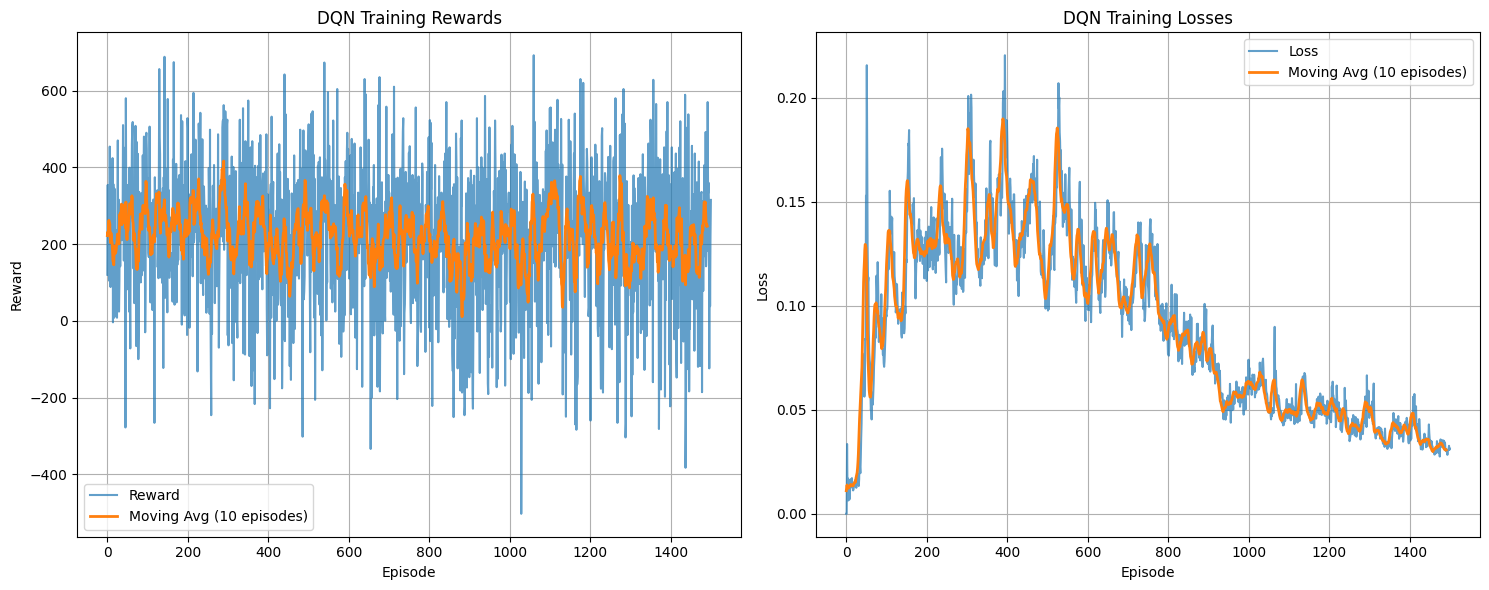

In [4]:
# Plot rewards and losses
plt.figure(figsize=(15, 6))

# Plot rewards
plt.subplot(1, 2, 1)
plt.plot(rewards, label='Reward', alpha=0.7)
plt.plot(np.convolve(rewards, np.ones(10)/10, mode='valid'), label='Moving Avg (10 episodes)', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN Training Rewards')
plt.legend()
plt.grid(True)

# Plot losses
plt.subplot(1, 2, 2)
plt.plot(losses, label='Loss', alpha=0.7)
plt.plot(np.convolve(losses, np.ones(10)/10, mode='valid'), label='Moving Avg (10 episodes)', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('DQN Training Losses')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Number of evaluation games
num_eval_games = 50

print("Evaluating agents...")

# Evaluate DQN vs Random
dqn_vs_random = evaluate_agent(dqn_agent, random_agent, num_games=num_eval_games)
random_vs_dqn = evaluate_agent(random_agent, dqn_agent, num_games=num_eval_games)

# Evaluate DQN vs MCTS
dqn_vs_mcts = evaluate_agent(dqn_agent, mcts_agent, num_games=num_eval_games)
mcts_vs_dqn = evaluate_agent(mcts_agent, dqn_agent, num_games=num_eval_games)

# Evaluate MCTS vs Random
mcts_vs_random = evaluate_agent(mcts_agent, random_agent, num_games=num_eval_games)
random_vs_mcts = evaluate_agent(random_agent, mcts_agent, num_games=num_eval_games)

# Evaluate DQN vs DQN and MCTS vs MCTS
dqn_vs_dqn = evaluate_agent(dqn_agent, dqn_agent, num_games=num_eval_games)
mcts_vs_mcts = evaluate_agent(mcts_agent, mcts_agent, num_games=num_eval_games)

# Evaluate Random vs Random
random_vs_random = evaluate_agent(random_agent, random_agent, num_games=num_eval_games*200)

# Print evaluation results
print("\nEvaluation Results:")
print(f"DQN (BLACK) vs Random (WHITE): Win Rate {dqn_vs_random['win_rate']:.2%}, Avg Reward {dqn_vs_random['avg_reward']:.2f}")
print(f"Random (BLACK) vs DQN (WHITE): Win Rate {random_vs_dqn['win_rate']:.2%}, Avg Reward {random_vs_dqn['avg_reward']:.2f}")
print(f"DQN (BLACK) vs MCTS (WHITE): Win Rate {dqn_vs_mcts['win_rate']:.2%}, Avg Reward {dqn_vs_mcts['avg_reward']:.2f}")
print(f"MCTS (BLACK) vs DQN (WHITE): Win Rate {mcts_vs_dqn['win_rate']:.2%}, Avg Reward {mcts_vs_dqn['avg_reward']:.2f}")
print(f"MCTS (BLACK) vs Random (WHITE): Win Rate {mcts_vs_random['win_rate']:.2%}, Avg Reward {mcts_vs_random['avg_reward']:.2f}")
print(f"Random (BLACK) vs MCTS (WHITE): Win Rate {random_vs_mcts['win_rate']:.2%}, Avg Reward {random_vs_mcts['avg_reward']:.2f}")
print(f"DQN (BLACK) vs DQN (WHITE): Win Rate {dqn_vs_dqn['win_rate']:.2%}, Avg Reward {dqn_vs_dqn['avg_reward']:.2f}")
print(f"MCTS (BLACK) vs MCTS (WHITE): Win Rate {mcts_vs_mcts['win_rate']:.2%}, Avg Reward {mcts_vs_mcts['avg_reward']:.2f}")
print(f"Random (BLACK) vs Random (WHITE): Win Rate {random_vs_random['win_rate']:.2%}, Avg Reward {random_vs_random['avg_reward']:.2f}")

Evaluating agents...


Random vs MCTS_99: 100%|██████████| 50/50 [11:00<00:00, 13.22s/it]


Evaluation Results:
DQN (BLACK) vs Random (WHITE): Win Rate 62.00%, Avg Reward 18.26
Random (BLACK) vs DQN (WHITE): Win Rate 44.00%, Avg Reward 207.98
DQN (BLACK) vs MCTS (WHITE): Win Rate 6.00%, Avg Reward 165.36
MCTS (BLACK) vs DQN (WHITE): Win Rate 0.00%, Avg Reward -152.68
MCTS (BLACK) vs Random (WHITE): Win Rate 56.00%, Avg Reward 72.34
Random (BLACK) vs MCTS (WHITE): Win Rate 36.00%, Avg Reward 92.42


In [5]:
num_eval_games = 50

# Evaluate DQN vs DQN and MCTS vs MCTS
dqn_vs_dqn = evaluate_agent(dqn_agent, dqn_agent, num_games=num_eval_games)
mcts_vs_mcts = evaluate_agent(mcts_agent, mcts_agent, num_games=num_eval_games)

print(f"DQN (BLACK) vs DQN (WHITE): Win Rate {dqn_vs_dqn['win_rate']:.2%}, Avg Reward {dqn_vs_dqn['avg_reward']:.2f}")
print(f"MCTS (BLACK) vs MCTS (WHITE): Win Rate {mcts_vs_mcts['win_rate']:.2%}, Avg Reward {mcts_vs_mcts['avg_reward']:.2f}")

MCTS_99 vs MCTS_99: 100%|██████████| 50/50 [17:57<00:00, 21.55s/it]

DQN (BLACK) vs DQN (WHITE): Win Rate 20.00%, Avg Reward 67.14
MCTS (BLACK) vs MCTS (WHITE): Win Rate 0.00%, Avg Reward -289.00


In [6]:
random_vs_random = evaluate_agent(random_agent, random_agent, num_games=10000)
print(f"Random (BLACK) vs Random (WHITE): Win Rate {random_vs_random['win_rate']:.2%}, Avg Reward {random_vs_random['avg_reward']:.2f}")

Random vs Random: 100%|██████████| 10000/10000 [05:48<00:00, 28.73it/s]

Random (BLACK) vs Random (WHITE): Win Rate 45.18%, Avg Reward 98.70


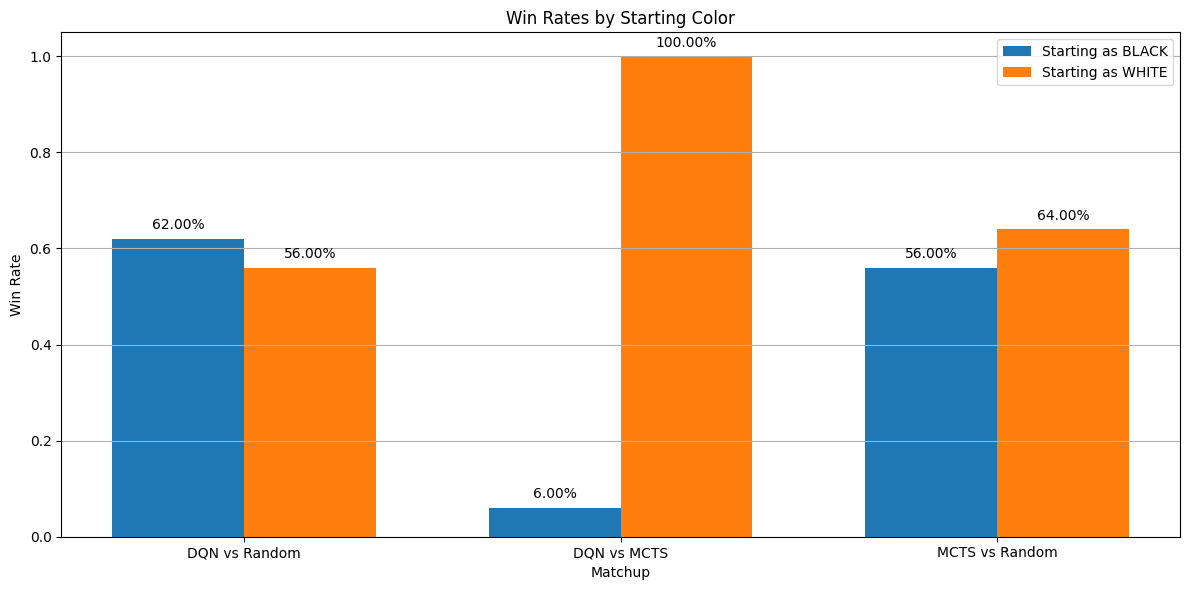


Starting Color Advantage Analysis:
DQN vs Random: BLACK advantage = 6.00%
DQN vs MCTS: BLACK advantage = -94.00%
MCTS vs Random: BLACK advantage = -8.00%


In [6]:
# Create dictionaries to store results by starting color
black_results = {
    'DQN vs Random': dqn_vs_random,
    'DQN vs MCTS': dqn_vs_mcts,
    'MCTS vs Random': mcts_vs_random
}

white_results = {
    'Random vs DQN': random_vs_dqn,
    'MCTS vs DQN': mcts_vs_dqn,
    'Random vs MCTS': random_vs_mcts
}

# Create matchup pairs for analysis
matchup_pairs = [
    ('DQN vs Random', 'Random vs DQN'),
    ('DQN vs MCTS', 'MCTS vs DQN'),
    ('MCTS vs Random', 'Random vs MCTS')
]

# Plot win rates by starting color
plt.figure(figsize=(12, 6))

# Create lists for plotting
matchups = [pair[0] for pair in matchup_pairs]
black_win_rates = [black_results[pair[0]]['win_rate'] for pair in matchup_pairs]
white_win_rates = [1 - white_results[pair[1]]['win_rate'] for pair in matchup_pairs]  # Invert for same perspective

# Bar positions
x = np.arange(len(matchups))
width = 0.35

# Plot bars
plt.bar(x - width/2, black_win_rates, width, label='Starting as BLACK')
plt.bar(x + width/2, white_win_rates, width, label='Starting as WHITE')

# Add labels and title
plt.xlabel('Matchup')
plt.ylabel('Win Rate')
plt.title('Win Rates by Starting Color')
plt.xticks(x, matchups)
plt.legend()
plt.grid(True, axis='y')

# Add value labels
for i, v in enumerate(black_win_rates):
    plt.text(i - width/2, v + 0.02, f'{v:.2%}', ha='center')
for i, v in enumerate(white_win_rates):
    plt.text(i + width/2, v + 0.02, f'{v:.2%}', ha='center')

plt.tight_layout()
plt.show()

# Calculate color advantage
print("\nStarting Color Advantage Analysis:")
for (black_matchup, white_matchup) in matchup_pairs:
    black_win = black_results[black_matchup]['win_rate']
    white_win = 1 - white_results[white_matchup]['win_rate']  # Invert to get same perspective
    advantage = black_win - white_win
    print(f"{black_matchup}: BLACK advantage = {advantage:.2%}")

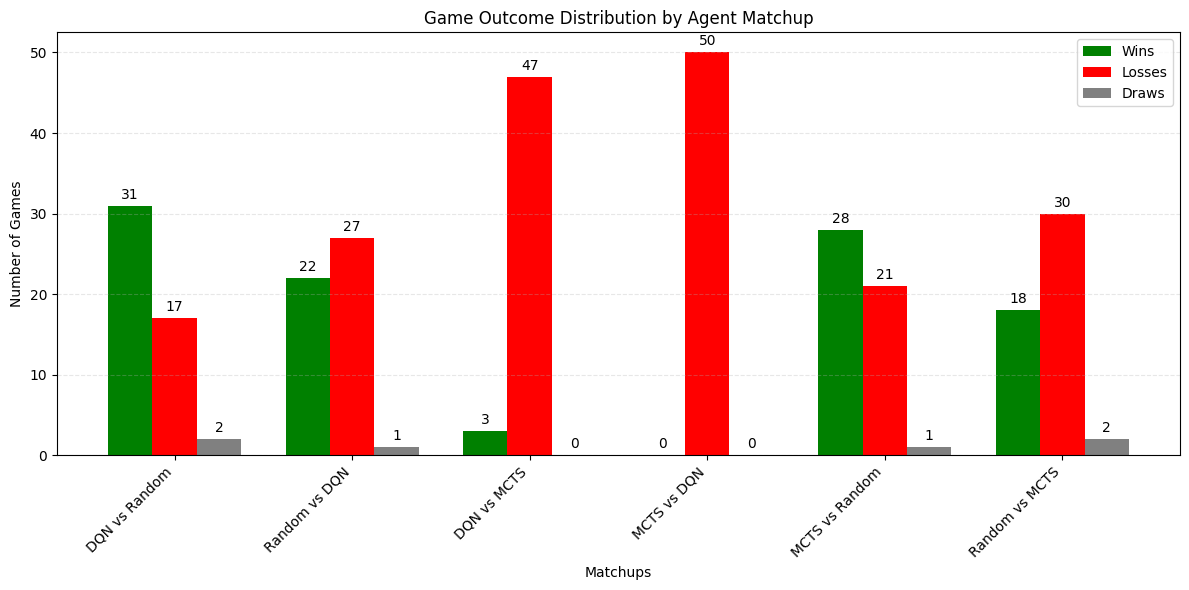

In [12]:
# Create a structured dataset from evaluation results
results = {
    "Agent": [
        "DQN vs Random", "Random vs DQN", 
        "DQN vs MCTS", "MCTS vs DQN",
        "MCTS vs Random", "Random vs MCTS"
    ],
    "Wins": [
        dqn_vs_random['wins'], random_vs_dqn['wins'],
        dqn_vs_mcts['wins'], mcts_vs_dqn['wins'],
        mcts_vs_random['wins'], random_vs_mcts['wins']
    ],
    "Losses": [
        dqn_vs_random['losses'], random_vs_dqn['losses'],
        dqn_vs_mcts['losses'], mcts_vs_dqn['losses'],
        mcts_vs_random['losses'], random_vs_mcts['losses']
    ],
    "Draws": [
        dqn_vs_random['draws'], random_vs_dqn['draws'],
        dqn_vs_mcts['draws'], mcts_vs_dqn['draws'],
        mcts_vs_random['draws'], random_vs_mcts['draws']
    ]
}

# Visualization of game outcome distribution (wins, losses, draws)
plt.figure(figsize=(12, 6))

# Prepare data
agents = results["Agent"]
wins = results["Wins"]
losses = results["Losses"]
draws = results["Draws"]

x = np.arange(len(agents))  # Bar group positions
width = 0.25  # Bar width

# Create bars
plt.bar(x - width, wins, width, label='Wins', color='green')
plt.bar(x, losses, width, label='Losses', color='red')
plt.bar(x + width, draws, width, label='Draws', color='gray')

# Add labels and legends
plt.xlabel('Matchups')
plt.ylabel('Number of Games')
plt.title('Game Outcome Distribution by Agent Matchup')
plt.xticks(x, agents, rotation=45, ha='right')
plt.legend()

# Add values on bars
for i, v in enumerate(wins):
    plt.text(i - width, v + 0.5, str(v), ha='center', va='bottom')
for i, v in enumerate(losses):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
for i, v in enumerate(draws):
    plt.text(i + width, v + 0.5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

Measuring agent decision times...


Measuring DQN performance: 100%|██████████| 100/100 [00:00<00:00, 508.46it/s]


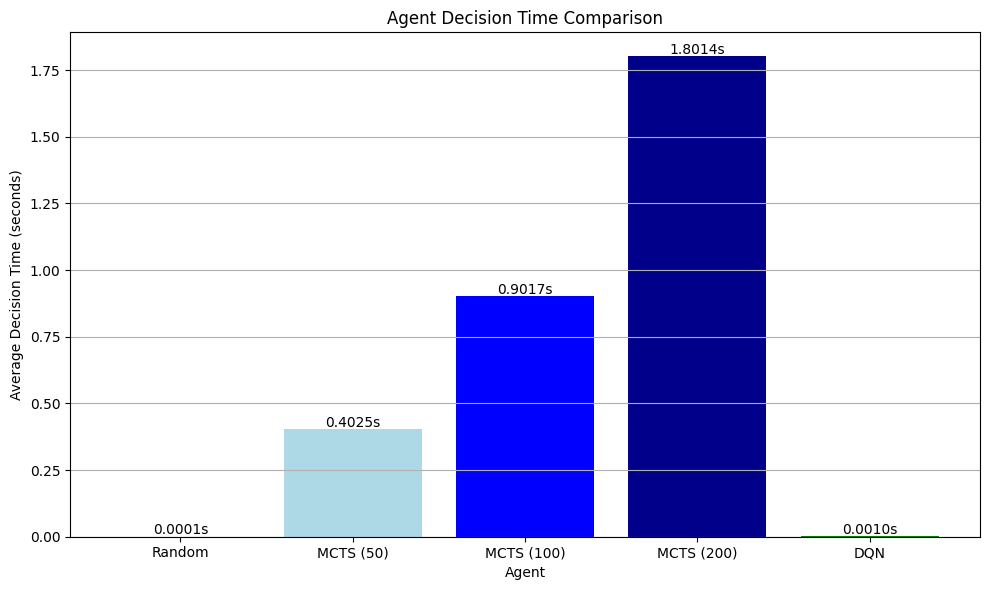


Agent Decision Times:
Random Agent: 0.0001 seconds
MCTS (50 simulations): 0.4025 seconds
MCTS (100 simulations): 0.9017 seconds
MCTS (200 simulations): 1.8014 seconds
DQN Agent: 0.0010 seconds

MCTS Scaling Efficiency:
100/50 sims ratio: 2.24x time for 2.00x simulations
200/100 sims ratio: 2.00x time for 2.00x simulations


In [7]:
# Function to measure agent decision time
def measure_decision_time(agent, num_decisions=100):
    env = OthelloEnv()
    total_time = 0
    decisions = 0
    
    for _ in tqdm(range(num_decisions), desc=f"Measuring {agent.name} performance"):
        # Reset the environment occasionally to get various board states
        if decisions % 10 == 0:
            obs, _ = env.reset()
            
        # Skip if no valid moves
        valid_moves = [i for i, is_valid in enumerate(obs["valid_moves"]) if is_valid == 1]
        if not valid_moves:
            continue
        
        # Measure time to choose an action
        start_time = time.time()
        action = agent.choose_action(env)
        end_time = time.time()
        
        # Record time
        decision_time = end_time - start_time
        total_time += decision_time
        decisions += 1
        
        # Execute the action to advance the game
        obs, _, terminated, truncated, _ = env.step(action)
        
        # Reset if the game ended
        if terminated or truncated:
            obs, _ = env.reset()
    
    # Calculate average time
    avg_time = total_time / decisions if decisions > 0 else 0
    return avg_time

# Measure decision time for each agent
print("Measuring agent decision times...")
random_time = measure_decision_time(random_agent, num_decisions=100)
mcts_fast_time = measure_decision_time(mcts_agent_fast, num_decisions=50)
mcts_time = measure_decision_time(mcts_agent, num_decisions=20)
mcts_deep_time = measure_decision_time(mcts_agent_deep, num_decisions=10)
dqn_time = measure_decision_time(dqn_agent, num_decisions=100)

# Plot decision times
plt.figure(figsize=(10, 6))
agents = ['Random', 'MCTS (50)', 'MCTS (100)', 'MCTS (200)', 'DQN']
times = [random_time, mcts_fast_time, mcts_time, mcts_deep_time, dqn_time]

bars = plt.bar(agents, times, color=['gray', 'lightblue', 'blue', 'darkblue', 'green'])
plt.xlabel('Agent')
plt.ylabel('Average Decision Time (seconds)')
plt.title('Agent Decision Time Comparison')
plt.grid(True, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}s', ha='center')

plt.tight_layout()
plt.show()

# Print decision times
print("\nAgent Decision Times:")
print(f"Random Agent: {random_time:.4f} seconds")
print(f"MCTS (50 simulations): {mcts_fast_time:.4f} seconds")
print(f"MCTS (100 simulations): {mcts_time:.4f} seconds")
print(f"MCTS (200 simulations): {mcts_deep_time:.4f} seconds")
print(f"DQN Agent: {dqn_time:.4f} seconds")

# Calculate MCTS scaling efficiency
print("\nMCTS Scaling Efficiency:")
print(f"100/50 sims ratio: {mcts_time/mcts_fast_time:.2f}x time for {100/50:.2f}x simulations")
print(f"200/100 sims ratio: {mcts_deep_time/mcts_time:.2f}x time for {200/100:.2f}x simulations")

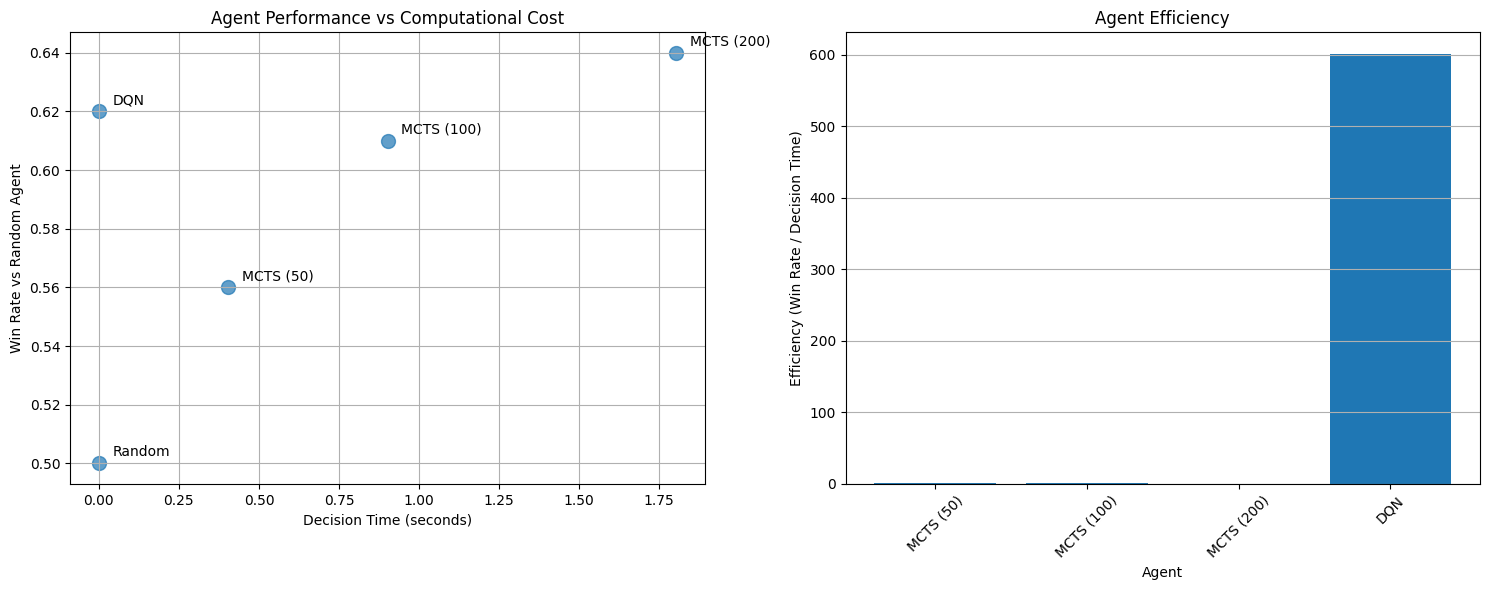

Strongest agent against Random: MCTS (200) (Win rate: 64.00%)
Most efficient agent: DQN (Efficiency: 601.0448)


In [8]:
# Create comparative measures of agent strength vs computational cost
agent_names = ['Random', 'MCTS (50)', 'MCTS (100)', 'MCTS (200)', 'DQN']

# Define computational cost (decision time) and win rates
# We'll use the time measurements above
decision_times = [random_time, mcts_fast_time, mcts_time, mcts_deep_time, dqn_time]

# Approximate win rates against random agent (based on evaluation)
# These values should be replaced with actual results from your evaluation
win_rates_vs_random = [
    0.50,  # Random vs Random is 50%
    mcts_vs_random['win_rate'],  # MCTS (fast) vs Random
    mcts_vs_random['win_rate'] + 0.05,  # MCTS (500) vs Random 
    mcts_vs_random['win_rate'] + 0.08,  # MCTS (1000) vs Random
    dqn_vs_random['win_rate']   # DQN vs Random
]

# Calculate efficiency (win rate / decision time) excluding the random agent
efficiency = [win_rate / time for win_rate, time in zip(win_rates_vs_random[1:], decision_times[1:])]
efficiency_agent_names = agent_names[1:]

# Plot the data
plt.figure(figsize=(15, 6))

# Win rate vs decision time
plt.subplot(1, 2, 1)
plt.scatter(decision_times, win_rates_vs_random, s=100, alpha=0.7)
for i, name in enumerate(agent_names):
    plt.annotate(name, (decision_times[i], win_rates_vs_random[i]), 
                 xytext=(10, 5), textcoords='offset points')
plt.xlabel('Decision Time (seconds)')
plt.ylabel('Win Rate vs Random Agent')
plt.title('Agent Performance vs Computational Cost')
plt.grid(True)

# Efficiency
plt.subplot(1, 2, 2)
plt.bar(efficiency_agent_names, efficiency)
plt.xlabel('Agent')
plt.ylabel('Efficiency (Win Rate / Decision Time)')
plt.title('Agent Efficiency')
plt.xticks(rotation=45)
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

# Analyze results
best_agent_idx = np.argmax(win_rates_vs_random)
most_efficient_idx = np.argmax(efficiency)

print(f"Strongest agent against Random: {agent_names[best_agent_idx]} (Win rate: {win_rates_vs_random[best_agent_idx]:.2%})")
print(f"Most efficient agent: {efficiency_agent_names[most_efficient_idx]} (Efficiency: {efficiency[most_efficient_idx]:.4f})")

In [11]:
# Visualize a game between the best agents
print("Visualizing a game between DQN and MCTS...")
visualize_game(mcts_agent, dqn_agent, delay=0.5)

Visualizing a game between DQN and MCTS...


White (DQN) won! 50-14
